Load packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_wine
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import ipywidgets as widgets
from ipywidgets import interact
from keras.models import Sequential
from keras.layers import Input, Dense
from tensorflow.keras.callbacks import EarlyStopping
from keras.optimizers import Adam

Load the wine dataset from Scikit-learn's built-in collection, including features and target labels.
This dataset contains information on different chemical properties of wines, which will be useful
for the clustering and and PCA analysis.

In [2]:
df = load_wine(as_frame=True)
df = df.frame
df = df.drop(columns=['target'])
df.head()


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


In [3]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=df)

https://docs.google.com/spreadsheets/d/1rO0udbY1-onnvgpdX8UFV8GLfrUEPVVe5DmZ6Qh9ZEA/edit#gid=0


Before proceeding with the analysis, we scale the data. This step standardizes the range of the
features, preventing variables with larger scales from dominating the results.

In [4]:
scaler = StandardScaler()

features = scaler.fit(df)
features = features.transform(df)

# Convert to pandas Dataframe
scaled_df = pd.DataFrame(features, columns=df.columns)
# Print the scaled data
scaled_df.head()
X = scaled_df.values


Next, we apply K-means clustering to the scaled data, determining the optimal number of clusters
using the elbow method. The elbow method helps identify the point where adding more clusters no
longer significantly improves the model’s performance, allowing us to choose the ideal number of
clusters for our analysis.

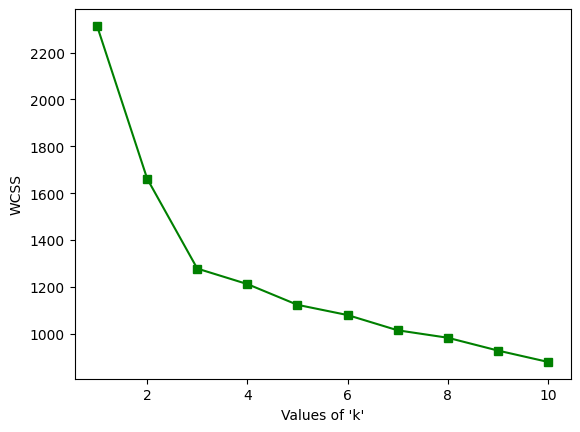

In [5]:
wcss = {}
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init="k-means++", random_state=42)
    kmeans.fit(X)
    wcss[i] = kmeans.inertia_

plt.plot(wcss.keys(), wcss.values(), "gs-")
plt.xlabel("Values of 'k'")
plt.ylabel("WCSS")
plt.show()


Based on the elbow method, it appears that three clusters is enough. We will now proceed to apply
K-means clustering with three cluster centers to segment the data.

In [6]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)

KMeans(n_clusters=3)

Next, we apply Principal Component Analysis (PCA) to reduce the dimensionality of the data,
extracting the first two principal components. This allows us to visualize the data in two
dimensions while preserving most of the variance.

In [7]:
pca = PCA(n_components=2)

reduced_X = pd.DataFrame(data=pca.fit_transform(X), columns=["PC1", "PC2"])
centers = pca.transform(kmeans.cluster_centers_)

# Reduced Features
reduced_X.head()


,PC1,PC2
0,3.316751,1.443463
1,2.209465,-0.333393
2,2.516740,1.031151
3,3.757066,2.756372
4,1.008908,0.869831


In [9]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=reduced_X)

https://docs.google.com/spreadsheets/d/1aK7pRAYUydet_8EG1thetiCNARigc9Ul5fHX9uHkgk8/edit#gid=0


We now visualize the first two principal components, with the data points colored according to their
cluster assignments. This visualization helps us understand how the clusters are distributed in the
reduced two-dimensional space.

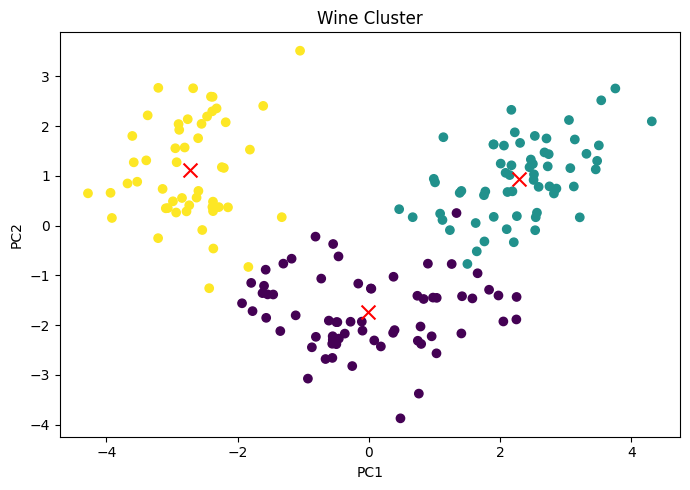

In [8]:
plt.figure(figsize=(7, 5))

# Scatter plot
plt.scatter(reduced_X["PC1"], reduced_X["PC2"], c=kmeans.labels_)
plt.scatter(centers[:, 0], centers[:, 1], marker="x", s=100, c="red")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Wine Cluster")
plt.tight_layout()


Now, let's take a look at how each feature loads onto the first two principal components.
This will show us which features have the biggest impact on the data’s variance in the reduced
space.

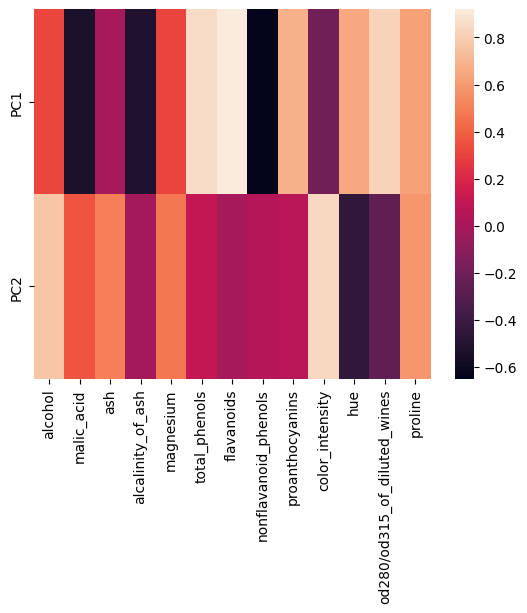

In [10]:
component_df = pd.DataFrame(
    (pca.components_.T * np.sqrt(pca.explained_variance_)).T,
    index=["PC1", "PC2"],
    columns=df.columns,
)
# Heat map
sns.heatmap(component_df)
plt.show()


The following interactive scatter plot shows the first two principal components of the wine dataset,
with data points color-coded by cluster assignment. You can select different features from the
dropdown to visualize how each feature is distributed across these two principal components. This
allows us to explore how the features relate to the two principal components.

**------self note------**

This block code contains older version **ipywidgets** that may be not savable onto Github. Github  has a newer version of **nbformat** and **nbconvert** that expect a "state" key to be present. To save this onto Github, either 1) clearout widget output, or 2) add a "state" key into every widget key.

    "widget0": {
    "_model_module": "@jupyter-widgets/controls",
    "_model_name": "IntSliderModel",
    "_view_module": "@jupyter-widgets/controls",
    "_view_name": "IntSliderView",
    "continuous_update": true,
    "description": "Value:",
    "disabled": false,
    "layout": {},
    "max": 100,
    "min": 0,
    "orientation": "horizontal",
    "readout": true,
    "readout_format": "d",
    "step": 1,
    "style": {},
    "state": {} // this is the "state" key to be added //
    },

In [12]:
def plot_scatter(variable):
    plt.figure(figsize=(10, 7))

    # Scatter plot with cluster colors
    scatter = plt.scatter(reduced_X["PC1"], reduced_X["PC2"], c=kmeans.labels_, cmap="viridis", s=30, alpha=0.7)

    # Plot cluster centers
    plt.scatter(centers[:, 0], centers[:, 1], marker="x", s=150, c="red", label="Cluster Centers")

    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("Wine Cluster with Annotated Labels")
    plt.legend()

    # Introduce small random noise to avoid overlap
    np.random.seed(42)  # For consistent results
    x_offsets = np.random.uniform(-0.2, 0.2, len(df))
    y_offsets = np.random.uniform(-0.2, 0.2, len(df))

    # Annotate points with the chosen variable
    for i, txt in enumerate(df[variable]):
        plt.annotate(
            txt,
            (reduced_X["PC1"][i] + x_offsets[i], reduced_X["PC2"][i] + y_offsets[i]),
            fontsize=8,
            ha="center", va="center",
        )

    plt.tight_layout()
    plt.show()

# Create a dropdown widget for selecting the variable
dropdown = widgets.Dropdown(
    options=df.columns,
    value='alcohol',
    description='Variable:',
    disabled=False,
    # To save this onto github, add "state" {} into the widget key
    # "state": {}
)

# Use interact to create an interactive plot
interact(plot_scatter, variable=dropdown)


interactive(children=(Dropdown(description='Variable:', options=('alcohol', 'malic_acid', 'ash', 'alcalinity_o…

<function __main__.plot_scatter(variable)>

By default, the dropdown above is set to alcohol, which has a strong influence on the second
principal component (PC2). You will notice that higher alcohol values tend to cluster at higher PC2
values. Similarly, malic acid plays a significant role in the first principal component (PC1). If
you select malic_acid from the dropdown, you'll observe that large values of malic acid are
primarily found at lower PC1 values. This reflects how the PCA transformation captures variations in
the dataset, with PC1 and PC2 separating key features into distinct clusters.

After exploring the linear dimensionality reduction technique PCA, we now turn to
Autoencoders (AEs), a neural network-based approach that generalizes PCA.
We begin with the linear Autoencoder, which, when trained with a mean squared error (MSE) loss and
linear activation, effectively learns principal components, much like PCA.
However, real-world data often exhibits nonlinear structures that PCA cannot capture. This is where
nonlinear Autoencoders come in. By introducing activation functions (e.g., sigmoid, relu), AEs can
learn complex, hierarchical representations that go beyond simple linear projections.

We now first look at a linear AE. A linear AE uses linear activation functions (line 7 and 9)
as well as the MSE as a loss function (line 12).

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 3)              │            42 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 13)             │            52 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94 (376.00 B)

 Trainable params: 94 (376.00 B)

 Non-trainable params: 0 (0.00 B)

None


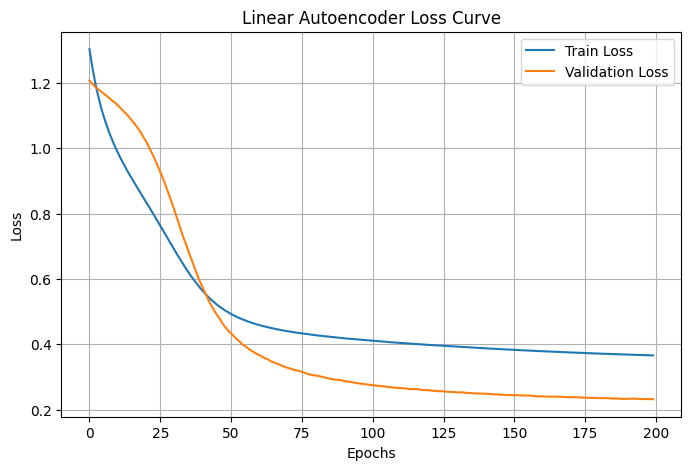

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


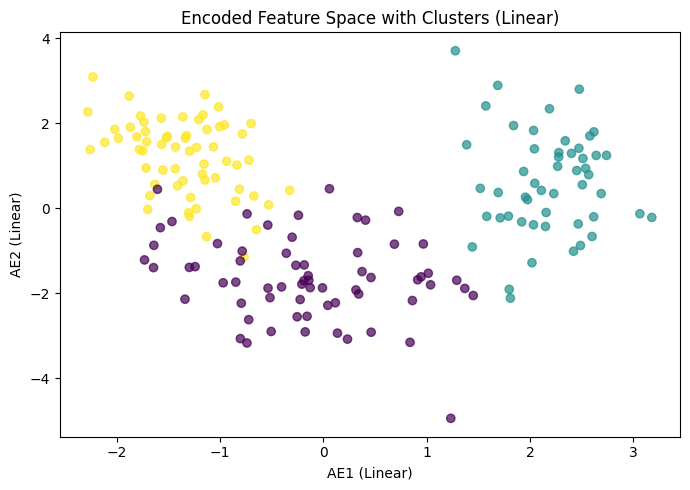

In [ ]:
# Define input dimensions
input_dim_linear = X.shape[1]
encoding_dim_linear = 3

# Define the autoencoder using Sequential API
autoencoder_linear = Sequential([
    Dense(encoding_dim_linear, activation='linear', input_shape=(input_dim_linear,)),  # Encoder
    Dense(input_dim_linear, activation='linear')  # Decoder
])

# Compile the model
autoencoder_linear.compile(optimizer='adam', loss='mse')

# Model summary
print(autoencoder_linear.summary())

history_linear = autoencoder_linear.fit(X, X,
                epochs=200,
                batch_size=16,
                shuffle=True,
                validation_split=0.1,
                verbose=0,)

# Plot training & validation loss
plt.figure(figsize=(8, 5))
plt.plot(history_linear.history['loss'], label='Train Loss')
plt.plot(history_linear.history['val_loss'], label='Validation Loss')
plt.title('Linear Autoencoder Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Extract encoded features (encoder part)
encoder_linear = Sequential([
    autoencoder_linear.layers[0]  # Extract only the encoder layer
])

encoded_data_linear = encoder_linear.predict(X)

# Scatter plot of encoded data
plt.figure(figsize=(7, 5))
plt.scatter(encoded_data_linear[:, 0], encoded_data_linear[:, 1], c=kmeans.labels_, cmap='viridis', alpha=0.7)
plt.xlabel("AE1 (Linear)")
plt.ylabel("AE2 (Linear)")
plt.title("Encoded Feature Space with Clusters (Linear)")
plt.tight_layout()
plt.show()



Now we do the same but this time with nonlinear activation functions (sigmoid).

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 3)              │            42 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 13)             │            52 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94 (376.00 B)

 Trainable params: 94 (376.00 B)

 Non-trainable params: 0 (0.00 B)

None


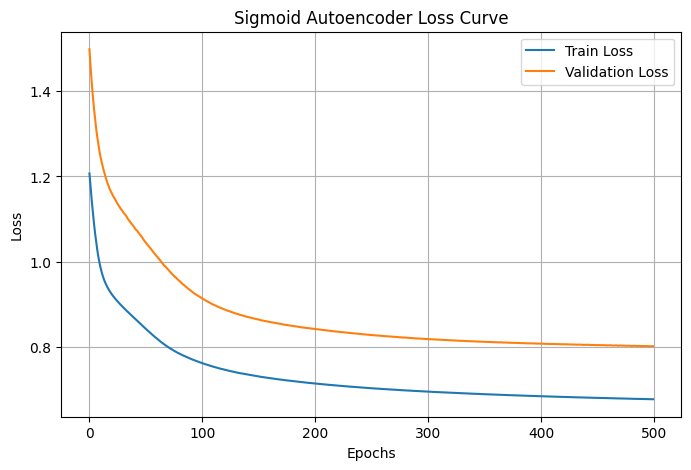

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


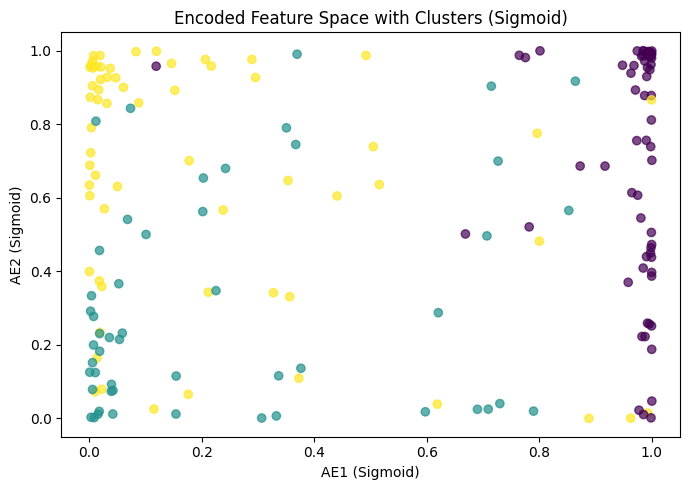

In [ ]:
# Define input dimensions
input_dim_sigmoid = X.shape[1]
encoding_dim_sigmoid = 3

# Autoencoder model with sigmoid activation
autoencoder_sigmoid = Sequential([
    Dense(encoding_dim_sigmoid, activation='sigmoid', input_shape=(input_dim_sigmoid,)),  # Encoder
    Dense(input_dim_sigmoid, activation='sigmoid')  # Decoder
])


# Increase the learning rate (e.g., 0.01)
higher_lr = 0.005
optimizer_high_lr = Adam(learning_rate=higher_lr)
autoencoder_sigmoid.compile(optimizer=optimizer_high_lr, loss='mse')

# Model summary
print(autoencoder_sigmoid.summary())


history_sigmoid = autoencoder_sigmoid.fit(X, X,
                epochs=500,
                batch_size=16,
                shuffle=True,
                validation_split=0.1,
                verbose=0,)

# Plot training & validation loss
plt.figure(figsize=(8, 5))
plt.plot(history_sigmoid.history['loss'], label='Train Loss')
plt.plot(history_sigmoid.history['val_loss'], label='Validation Loss')
plt.title('Sigmoid Autoencoder Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Encoder model to extract encoded representations
encoder_sigmoid = Sequential([
    autoencoder_sigmoid.layers[0]  # Extract only the encoder layer
])
encoded_data_sigmoid = encoder_sigmoid.predict(X)

# Scatter plot of encoded data
plt.figure(figsize=(7, 5))
plt.scatter(encoded_data_sigmoid[:, 0], encoded_data_sigmoid[:, 1], c=kmeans.labels_, cmap='viridis', alpha=0.7)
plt.xlabel("AE1 (Sigmoid)")
plt.ylabel("AE2 (Sigmoid)")
plt.title("Encoded Feature Space with Clusters (Sigmoid)")
plt.tight_layout()
plt.show()
